In [95]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from pathlib import Path
from tensorflow.keras.models import load_model
import os
from tensorflow.keras.applications import ResNet50V2
from sklearn.model_selection import StratifiedKFold, train_test_split
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import albumentations as A

tf.__version__

'2.4.1'

In [96]:
PATH = '/kaggle/input/'

os.listdir(PATH)

['dataset-melanoma224', 'melanoma224']

In [97]:
train = pd.read_csv(f'{PATH}/dataset-melanoma224/subset.csv')
val = pd.read_csv(f'{PATH}/dataset-melanoma224/val_split.csv')
train.shape, val.shape


((2220, 8), (10932, 8))

In [101]:
BATCH_SIZE = 64
AUTO = tf.data.experimental.AUTOTUNE # Permite obtener el numero de cpu 


def decode(name, label):
    img = tf.io.read_file(name)
    img = tf.image.decode_jpeg(img,channels=3)
    img = tf.cast(img, tf.float32)
    return img,label

def augment(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    return img, label

def load_ds(df):
    options = tf.data.Options()
    options.experimental_deterministic = False
    #---------------
    imgs , labels = df["image_name"].values, df["target"].values
    imgs = [f'{PATH}/melanoma224/jpeg224/train/{name}.jpg' for name in imgs]
    ds = tf.data.Dataset.from_tensor_slices((imgs,labels))
    ds = ds.with_options(options) # Aplicamos las opciones que hemos puesto
    ds = ds.map(decode, num_parallel_calls=AUTO)
    ds = ds.map(augment, num_parallel_calls=AUTO)
    df = ds.cache() 
    ds = ds.shuffle(2048)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size = AUTO) # Mientras la gpu esta calculando la cpu vaya leyendo imagenes
    return ds


In [102]:
train_ds = load_ds(train)
val_ds = load_ds(val)

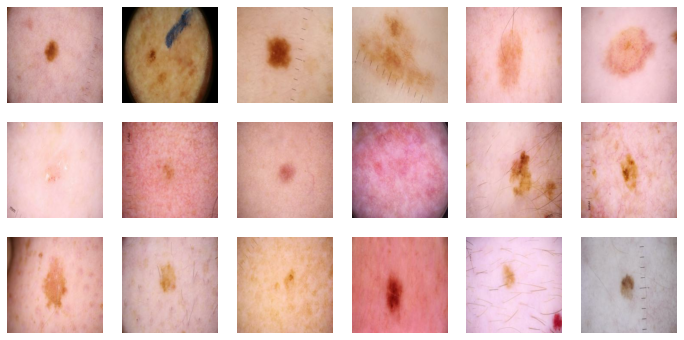

In [103]:
r, c = 3,6
fig = plt.figure(figsize=(2*c,2*r))
for _r in range(r):
    for _c in range(c):
        plt.subplot(r,c, _r*c + _c + 1)
        for imgs, labels in train_ds.take(1):
            img = imgs[0].numpy()/255 #El decode hemos puesto que nuestro datos sean float y da problea si es el numero entre 0-255 float por eso hay que pasarlo a int 
            plt.imshow(img)
            plt.axis(False)
plt.show()

In [104]:
IMAGE_SIZE = (224,224,3)

encoder = ResNet50V2(
    include_top=False,
    input_shape=IMAGE_SIZE,
    weights='imagenet'
)
encoder.trainable=False
inputs = keras.Input(shape=IMAGE_SIZE)
#x = keras.layers.experimental.preprocessing.RandomFlip()(inputs)# Aplicamos las transformaciones directamente en la capa neuronal. Las transformaciones las hara la gpu en vez de la cpu
x = keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)
x = encoder(x, training = False)
x = keras.layers.GlobalAveragePooling2D()(x)
ouputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, ouputs)
model.summary()




Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
rescaling_5 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 2049      
Total params: 23,566,849
Trainable params: 2,049
Non-trainable params: 23,564,800
_________________________________________________________________


In [105]:
#Compilamos el modelo
model.compile(
optimizer=keras.optimizers.Adam(),
loss=keras.losses.BinaryCrossentropy(),
metrics=[keras.metrics.AUC(name="auc")]
)

In [106]:

# Creamos nuestra callbacks
filepath = f"kaggle/working/checkpoints/checkpoint"
cb = tf.keras.callbacks.ModelCheckpoint(
filepath=filepath,
monitor="val_auc",
verbose=1,
save_best_only=True,
save_weights_only=True, # Guardar todo el modelo o solo los pesos
mode="max", # Guardara el valor maximo del parametro que monitorizamos, en caso de loss poner "min"
)

In [107]:
#Entrenamos nuestro modelo
model.fit(train_ds,
      epochs=10,
      validation_data=val_ds,
      validation_steps=10,
      callbacks=[cb])

Epoch 1/10
35/35 [==============================] - 13s 241ms/step - loss: 0.2020 - auc: 0.5009 - val_loss: 0.1028 - val_auc: 0.4887

Epoch 00001: val_auc improved from -inf to 0.48873, saving model to kaggle/working/checkpoints/checkpoint
Epoch 2/10
35/35 [==============================] - 8s 180ms/step - loss: 0.1063 - auc: 0.5281 - val_loss: 0.0701 - val_auc: 0.5685

Epoch 00002: val_auc improved from 0.48873 to 0.56853, saving model to kaggle/working/checkpoints/checkpoint
Epoch 3/10
35/35 [==============================] - 8s 187ms/step - loss: 0.0811 - auc: 0.7069 - val_loss: 0.0909 - val_auc: 0.6373

Epoch 00003: val_auc improved from 0.56853 to 0.63734, saving model to kaggle/working/checkpoints/checkpoint
Epoch 4/10
35/35 [==============================] - 8s 188ms/step - loss: 0.0801 - auc: 0.7752 - val_loss: 0.0822 - val_auc: 0.7377

Epoch 00004: val_auc improved from 0.63734 to 0.73768, saving model to kaggle/working/checkpoints/checkpoint
Epoch 5/10
35/35 [================

In [108]:
# Al final de cada for cargamos los mejores pesos
model.load_weights(filepath)
model.save(f"/kaggle/working/model1.h5")# Deberemos indicar nombres diferentes para guardar los diferentes modelos que generemos

In [110]:
# Cargamos las metricas
_, auc = model.evaluate(val_ds) # Evaluate nos devolverá la "loss" y la metrica "auc"
aucs.append(auc)
    
    

171/171 [==============================] - 22s 116ms/step - loss: 0.0795 - auc: 0.7763


In [111]:
aucs

[0.791947603225708, 0.7654978036880493, 0.7762972116470337]

In [114]:
m = tf.keras.metrics.AUC()
aucs = []
for imgs, labels in val_ds:
    imgs_lr = tf.image.flip_left_right(imgs)
    imgs_ud = tf.image.flip_up_down(imgs)
    preds = (model.predict(imgs)+model.predict(imgs_lr)+model.predict(imgs_ud))/3
    _ = m.update_state(labels, preds)
    aucs.append(m.result().numpy())

In [116]:
preds

array([[9.91102657e-04],
       [7.34505989e-03],
       [9.34736244e-03],
       [6.98442163e-04],
       [5.32139605e-03],
       [2.12698174e-03],
       [8.70118849e-03],
       [9.04274930e-04],
       [7.71530857e-03],
       [8.00312671e-04],
       [3.21904309e-02],
       [9.88820684e-04],
       [2.45452374e-02],
       [1.45171967e-03],
       [4.98721860e-02],
       [9.04683664e-04],
       [1.22329295e-02],
       [6.37750840e-03],
       [1.19411498e-02],
       [1.97990704e-03],
       [4.79807556e-02],
       [8.36077612e-04],
       [2.00601015e-03],
       [4.33308352e-03],
       [9.91503615e-03],
       [1.05871474e-02],
       [9.63321235e-03],
       [2.16756272e-03],
       [1.96222938e-03],
       [1.04396725e-02],
       [1.03730969e-02],
       [5.46780089e-03],
       [2.58732289e-01],
       [4.28199535e-03],
       [6.63771993e-03],
       [8.14762432e-03],
       [1.43245095e-03],
       [2.57011881e-04],
       [2.02361750e-03],
       [1.28297629e-02],


Nuestro resultado con las transformaciones en la capa ha sido 0.76549 menor que hacer las transformaciones en la carga

In [117]:
np.mean(aucs),np.std(aucs)

(0.7889333, 0.03186122)

In [122]:

test = pd.read_csv(f'{PATH}/melanoma224/test.csv')
BATCH_SIZE = 64

def decode_test(name):
    img = tf.io.read_file(name)
    img = tf.image.decode_jpeg(img,channels=3)
    img = tf.cast(img, tf.float32)
    return img


def load_test_ds(df):
    imgs  = df["image_name"].values
    imgs = [f'{PATH}/melanoma224/jpeg224/test/{name}.jpg' for name in imgs]
    ds = tf.data.Dataset.from_tensor_slices(imgs)
    ds = ds.map(decode_test, num_parallel_calls=AUTO)
    ds = ds.batch(BATCH_SIZE)
    return ds

In [123]:
test_ds = load_test_ds(test)


In [125]:
preds = []
for imgs in test_ds:
    imgs_lr = tf.image.flip_left_right(imgs)
    imgs_ud = tf.image.flip_up_down(imgs)
    _preds = (model.predict(imgs)+model.predict(imgs_lr)+model.predict(imgs_ud))/3
    preds+= _preds.ravel().tolist()

In [126]:
preds

[0.004211128689348698,
 0.002629287773743272,
 0.00918986089527607,
 0.0009134045685641468,
 0.002157775918021798,
 0.012804883532226086,
 0.0013239368563517928,
 0.11298202723264694,
 0.007063429802656174,
 0.003910561557859182,
 0.01346785668283701,
 0.0006027552299201488,
 0.00962570309638977,
 0.0013666547602042556,
 0.018508555367588997,
 0.0038655053358525038,
 0.0017354587325826287,
 0.0014329008990898728,
 0.011054929345846176,
 0.08440477401018143,
 0.007046394050121307,
 0.0021558792795985937,
 0.015363563783466816,
 0.007683268282562494,
 0.02221844159066677,
 0.01728871278464794,
 0.0027979444712400436,
 0.007753793150186539,
 0.002105545252561569,
 0.003375766798853874,
 0.013706847093999386,
 0.003643693635240197,
 0.02032514102756977,
 0.022721974179148674,
 0.011880193836987019,
 0.0008520668488927186,
 0.00803675502538681,
 0.032328810542821884,
 0.0007184957503341138,
 0.0021898930426687002,
 0.0020949621684849262,
 0.05930076912045479,
 0.05885620042681694,
 0.002947

In [127]:
submission = pd.DataFrame({
    'image_name':test['image_name'].values,
    'target':preds
})

In [128]:
submission.to_csv("/kaggle/working/submission.csv", index=False)
